In [1]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# TODO

- is odeint usage possible? by passing run_step as function (any_object?), instead passing array values?
- is a 3D implementation possible as of now? try!
- can I somehow make this more clearly structured? and easier to add new processes? DOCUMENT CODE WELL! (then share with Benoît)


# NOTES:
### 1. intent is very important! needs to have a proper routing!

In [337]:
@xs.process
class Component:
    """Base class encoding behaviour for a component of a ecosystem.
        subclass needs to have implemented:
        self.component_label, self.init, 
        
    """
    num = xs.variable(dims=(),intent='in')

    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.delta = sum((v for v in self.fluxes)) * dt  #maybe can remove forcing to numpy array here later


    
    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        self.state += self.delta * self.state
        


        
@xs.process
class Nutrient(Component):
    """"""
    N = xs.index(dims='N')
    component_label = xs.variable(default='N', groups='component-label', static=True)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})

    # PARAMETERS / INPUTS
    num = xs.variable(default=1, static=True, description='number of nutrients (1 by default)')
    
    def initialize(self):
        self.time = 0
        self.N = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
            
@xs.process
class Phytoplankton(Component):
    """"""
    P = xs.index(dims='P')
    component_label = xs.variable(default='P', groups='component-label', static=True)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS / INPUTS
    halfsat = xs.variable(intent='in', dims='P', groups='parameters')
    
    def initialize(self):
        self.time = 0
        self.P = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])

In [338]:
@xs.process
class NutrientUptake:
    """"""
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
    uptake = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth'
    )
    
    N = xs.foreign(Nutrient, 'state', intent='in')
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat', intent='in')
    
    def run_step(self):
        nutrient_uptake = self.N / (self.P_halfsat + self.N)
        self.growth = np.array(nutrient_uptake, dtype='float64')
        self.uptake = np.array(- sum(nutrient_uptake), dtype='float64')

        
@xs.process
class PhytoMortality:
    """"""
    mortality = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    
    def run_step(self):
        self.mortality = - sum(np.array([0.1], dtype='float64')) * self.P
    
@xs.process
class NutrientSource:
    """Chemostat constant nutrient inflow from one direction"""
    supply = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth'
    )

    N = xs.foreign(Nutrient, 'state')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.supply = np.array(0.1, dtype='float64')

In [363]:
@xs.process
class ChemostatSetup:
    P_num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    P_initVal = xs.variable(intent='in', dims=[(), 'P'], description='initial Phytoplankton biomass')
    halfsat = xs.variable(intent='in', dims=[(), 'P'], static=True, description='half-saturation constant of nutrient uptake for P')

    N_initVal = xs.variable(intent='in', static=True, description='initial Nutrient concentration')
    
    P_num_out = xs.foreign(Phytoplankton, 'num', intent='out')    
    P_init = xs.foreign(Phytoplankton, 'state', intent='out')
    halfsat_out = xs.foreign(Phytoplankton, 'halfsat', intent='out')
    
    N_init = xs.foreign(Nutrient, 'state', intent='out')

    
    def initialize(self):
        print('init')
        self.P_num_out = self.P_num
        self.halfsat_out = np.array([self.halfsat + i/2 for i in range(self.P_num)], dtype='float64')
        self.P_init = np.array([self.P_initVal for i in range(self.P_num)], dtype='float64')
        self.N_init = np.array([self.N_initVal for i in range(1)], dtype='float64')

In [364]:
mod = xs.Model(
    {
        'ModelSetup':ChemostatSetup,
        'N':Nutrient, 
        'P':Phytoplankton, 
        'N_Uptake':NutrientUptake,
        'P_Mortality':PhytoMortality,
        'N_source':NutrientSource
    }
)

In [365]:
mod

<xsimlab.Model (6 processes, 7 inputs)>
ModelSetup
    P_initVal           [in] () or ('P',) initial Phytoplankton bio...
    P_num               [in] number of Phytoplankton
    N_initVal           [in] initial Nutrient concentration
    halfsat             [in] () or ('P',) half-saturation constant ...
N_source
N_Uptake
N
    component_label     [in]
    num                 [in] number of nutrients (1 by default)
P_Mortality
P
    component_label     [in]

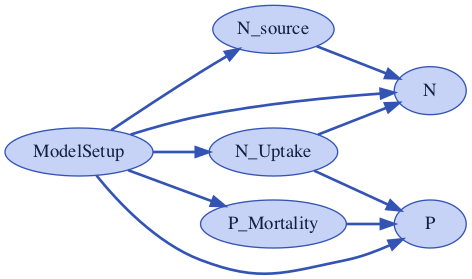

In [372]:
mod.visualize()

In [366]:
#mod.visualize(show_inputs=False, show_variables=True)

In [373]:
in_ds = xs.create_setup(
     model=mod,
     clocks={
         'time': np.linspace(0., 200., 3000)
     },
     master_clock='time',
     input_vars={
         'ModelSetup':{'P_num':1,'P_initVal':1,'halfsat':0.5, 'N_initVal':1}
     },
     output_vars={
        'P__state': 'time',
        'N__state': 'time'
     }
 )

In [374]:
with mod:
    out_ds = in_ds.xsimlab.run()

init


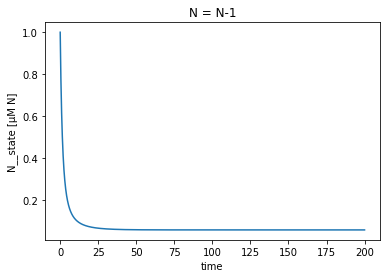

In [375]:
out_ds.N__state.plot()

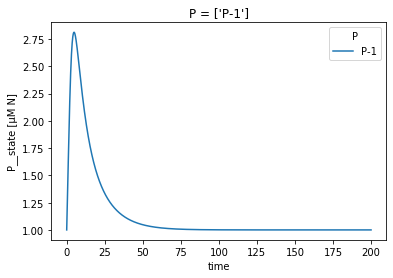

In [376]:
out_ds.P__state.plot.line(x='time')

In [377]:
out_ds

<xarray.Dataset>
Dimensions:                (N: 1, P: 1, time: 3000)
Coordinates:
  * N                      (N) <U3 'N-1'
  * P                      (P) <U3 'P-1'
  * time                   (time) float64 0.0 0.06669 0.1334 ... 199.9 200.0
Data variables:
    ModelSetup__N_initVal  int64 1
    ModelSetup__P_initVal  int64 1
    ModelSetup__P_num      int64 1
    ModelSetup__halfsat    float64 0.5
    N__component_label     <U1 'N'
    N__num                 int64 1
    N__state               (time, N) float64 1.0 0.9622 ... 0.05556 0.05556
    P__component_label     <U1 'P'
    P__state               (time, P) float64 1.0 1.038 1.076 ... 1.0 1.0 1.0

In [325]:
out_ds.N__state.values

array([[1.        ],
       [0.96766505],
       [0.93673099],
       ...,
       [0.01020408],
       [0.01020408],
       [0.01020408]])

In [326]:
out_ds.P__state.values

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.00566695, 1.00566695, 1.00566695, 1.00566695, 1.00566695],
       [1.01128646, 1.01128646, 1.01128646, 1.01128646, 1.01128646],
       ...,
       [0.20371516, 0.20371516, 0.20371516, 0.20371516, 0.20371516],
       [0.20371441, 0.20371441, 0.20371441, 0.20371441, 0.20371441],
       [0.20371365, 0.20371365, 0.20371365, 0.20371365, 0.20371365]])

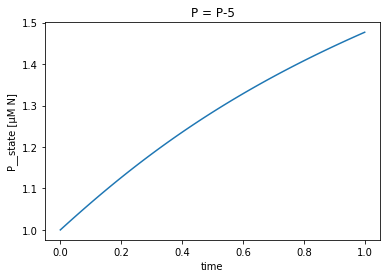

In [114]:
out_ds.P__state.sel(P='P-5').plot()